# OASIS Brains Data Handling

We shall be using the `OASIS-1: Cross-sectional MRI Data in Young, Middle Aged, Nondemented and Demented Older Adults` dataset.

__Summary:__ This set consists of a cross-sectional collection of 416 subjects aged 18 to 96. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 100 of the included subjects over the age of 60 have been clinically diagnosed with very mild to moderate Alzheimer’s disease (AD). Additionally, a reliability data set is included containing 20 nondemented subjects imaged on a subsequent visit within 90 days of their initial session.

In [185]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Patient Metadata

First we shall handle the CSV file which contains the metadata for each of the patients.

In [92]:
oasis_dir = "/Data/OASIS"
meta_path = os.path.join(oasis_dir, "oasis_cross-sectional.csv")

df = pd.read_csv(meta_path)
df.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [39]:
df.dtypes

ID        object
M/F       object
Hand      object
Age        int64
Educ     float64
SES      float64
MMSE     float64
CDR      float64
eTIV       int64
nWBV     float64
ASF      float64
Delay    float64
dtype: object

### Missing values

Just inspecting the head of the dataframe above you can see there are some missing values. Lets see how many are missing from each feature.

In [18]:
print(f"Number of patients: {len(df)}")
df.isna().sum()

Number of patients: 436


ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64

### Get AD subjects

We are particularly interested in the `CDR` column. This is the clinical dementia rating; a numeric scale used to quantify the severity of the symptoms of dementia determined by the patient's physician.

The scale is:

|CDR |Description |
|:-- |:--         |
|0   |No dementia | 
|0.5 |Very mild dementia | 
|1   |Mild dementia | 
|2   |Moderate dementia | 

We have 201 missing values from 436 patients (46%). This is a large percentage of the population, lets see how the remaining values are distributed across the possible ratings.

[(0.0, 135), (0.5, 70), (1.0, 28), (2.0, 2)]


Text(0, 0.5, 'Number of Patients')

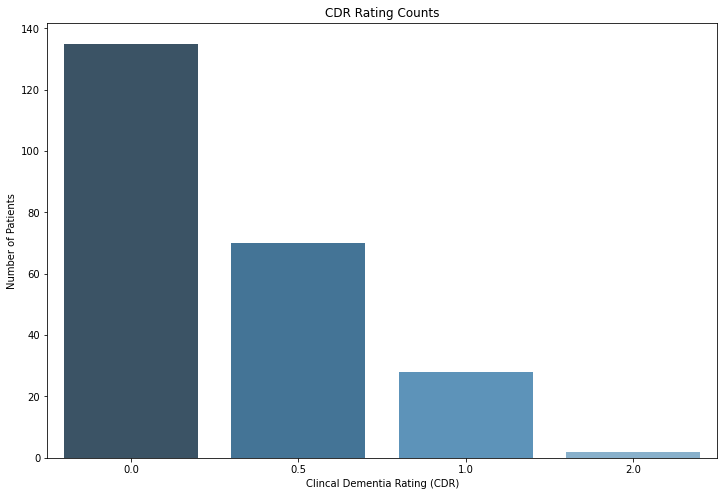

In [156]:
ratings = df["CDR"].dropna().sort_values().unique()
counts = df["CDR"].value_counts()

print([(rating, count) for (rating, count) in zip(ratings, counts)])

fig = plt.figure(figsize=(12,8))
sns.barplot(ratings, counts, palette="Blues_d")
plt.title("CDR Rating Counts")
plt.xlabel("Clincal Dementia Rating (CDR)")
plt.ylabel("Number of Patients")

We have a total of 235 patients with a given CDR, 135 (57%) of them being patients with no signs of dementia and 100 (43%) with. 

As we are interested in detecting patients with AD we shall create a binary label signifying a CDR greater than 0. We shall also drop any rows with missing values.

In [173]:
cdr_df = df.dropna(subset=["CDR"])[["ID", "CDR"]].copy()

cdr_df["AD"] = cdr_df["CDR"] > 0
cdr_df["AD"] = cdr_df["CDR"].isna()
cdr_df

,ID,CDR,AD
0,OAS1_0001_MR1,0.0,False
1,OAS1_0002_MR1,0.0,False
2,OAS1_0003_MR1,0.5,False
8,OAS1_0010_MR1,0.0,False
9,OAS1_0011_MR1,0.0,False
...,...,...,...
411,OAS1_0453_MR1,0.5,False
412,OAS1_0454_MR1,0.5,False
413,OAS1_0455_MR1,0.0,False
414,OAS1_0456_MR1,0.0,False


## MRI Slices

The OASIS contains MRI volumes of each patient. Also included are pre-processed slices and volumes, including grey-white matter segmentation masks. Grey and white matter astrophy is thought to be an indicator or Alzheimer's disease so it makes sense to try these segmented volumes as our training data. FSL_SEG directory includes the grey/white/CSF segmentation image generated from the masked atlas image.

In [139]:
data_dir = os.path.join(oasis_dir, "data")
subjects = cdr_df["ID"].tolist()

slice_paths = []
for subject in subjects:
    fsl_dir = os.path.join(data_dir, "{0}/FSL_SEG".format(subject))
    subject_slices = [os.path.join(fsl_dir,slice) for slice in os.listdir(fsl_dir) if slice[-4:] == ".gif"]
    slice_paths += subject_slices

print(f"found {len(slice_paths)} slices")

found 235 slices


Now we can load in the images.

In [147]:
slices = [plt.imread(path) for path in slice_paths]
print(f"loaded {len(slices)} slices")

loaded 235 slices


Lets visualise some of the images.

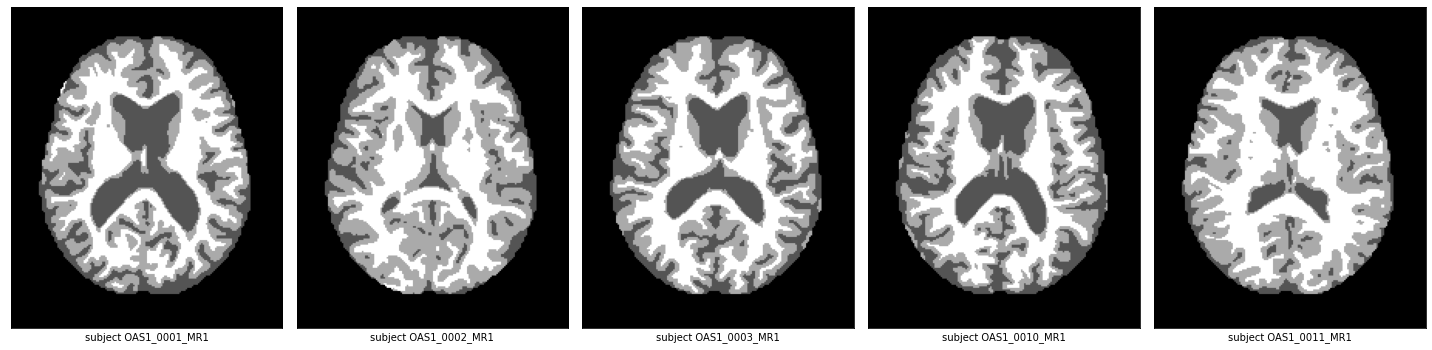

In [151]:
fig = plt.figure(figsize=(20,5))
for i, idx in enumerate(np.random.choice(len(slices), 5)):
    fig.add_subplot(1, 5, i+1)
    plt.imshow(slices[i], cmap="gray")
    plt.xlabel("subject {0}".format(subjects[i]))
    plt.xticks([])
    plt.yticks([])
fig.tight_layout()

### Create test and train sets

Now we have the images and their AD label we can create test and train sets.

First we shall replace the `AD` column with binary values.

In [177]:
ad_dict = {"AD": {False: 0, True: 1}}
y = cdr_df.replace(ad_dict, inplace=False)["AD"].tolist()


Now we can create the test and train sets.

In [190]:
X = np.asarray(slices)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

print(f"total:\t{len(X)}\ntrain:\t{len(X_train)}\nval:\t{len(X_val)}\ntest:\t{len(X_test)}")



total:	235
train:	189
val:	22
test:	24


## Save to project directory

Now we have the training sets we can save them to the project directory.

In [215]:
def getdirs(classes):
    data_dir = os.path.join(os.path.join(os.getcwd(), os.pardir), "resources/data/oasis")
    dir_sets = []
    for s in ["train", "val", "test"]:
        dirs = []
        for c in classes:
            dir = "{0}/{1}/".format(s, c)
            dirs.append(os.path.join(data_dir, dir))
        dir_sets.append(dirs)
    return dir_sets

def mkdirs(classes):
    dir_sets = getdirs(classes)
    for dirs in dir_sets:
        for dir in dirs:
            if not os.path.isdir(dir):    
                os.makedirs(dir)
            else:
                for filepath in os.listdir(dir):
                    os.remove(os.path.join(dir, filepath))
 
def write_imgs(classes, X_train, y_train, X_val, y_val, X_test, y_test):
    dir_sets = getdirs(classes)
    sets = [(X_train, y_train), (X_val, y_val), (X_test, y_test)]
    for (dirs, (X, y)) in zip(dir_sets, sets):
        counter = [0] * len(classes)
        for (img, label) in zip(X, y):
            filename = "{0}class_{1}_img_{2}.png".format(dirs[label], label, counter[label])
            cv.imwrite(filename, img)
            counter[label] += 1

classes = range(2)
mkdirs(classes)
write_imgs(classes, X_train, y_train, X_val, y_val, X_test, y_test)

Check all images were written.

In [250]:
tsets = ["train", "val", "test"]

counts = []
for tset, ddir in zip(tsets, getdirs(classes)):
    count = 0
    for cdir in ddir:
        count += len(os.listdir(cdir))
    counts.append((tset, count))

print(f"total images found: {counts[0][1]+counts[1][1]+counts[2][1]}")
for tset, count in counts:
    print(f"found {count} images in {tset} set")


total images found: 235
found 189 images in train set
found 22 images in val set
found 24 images in test set
